In [1]:
#%pip install laspy[lazrs,laszip]

In [7]:
import laspy as lp
from laspy.file import File
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import islice
from itertools import cycle
import math
#%pip install open3d
import open3d as o3d
import random
from sklearn import cluster, mixture
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
import time
import pandas as pd
import seaborn as sns
from sklearn import metrics

In [2]:
file = '/home/tsgleeds2021/Desktop/Track_B_20200706_104026 Profiler.zfs_1.las'
# this line works with the new laspy (2.0)
las = lp.read(file)

In [4]:
#Define a function that takes as input an array of points, and a voxel size expressed in meters. It returns the sampled point cloud
def grid_subsampling(points, voxel_size):

  nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
  non_empty_voxel_keys, inverse, nb_pts_per_voxel= np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
  idx_pts_vox_sorted=np.argsort(inverse)
  voxel_grid={}
  grid_barycenter,grid_candidate_center=[],[]
  last_seen=0

  for idx,vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)]=points[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
    grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)]-np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
    last_seen+=nb_pts_per_voxel[idx]

  return grid_candidate_center

In [3]:
def ground_segmentation(data,classes):
    #initialize the data
    idx_segmented = []
    segmented_cloud = []
    MAX_iters = 100
    # the maximum difference that between data and model
    sigma = 0.2 #000000.bin:0.15, 000001:0.2， 002000：0.35
    
    best_a = 0
    best_b = 0
    best_c = 0
    best_d = 0
    pretotal = 0
    # expected probability of correct model
    P = 0.99
    #total number of points
    n = len(data)
    cluster_index = np.zeros(n,dtype=int)
    outline_ratio = 0.5 #000000.bin:0.6,000001.bin:0.5， 002000：0.7
    for i in range(MAX_iters):
        ground_cloud = []
        idx_ground = []
        #step #1: select the minimum subset to predict the model, it's 3 points for a plane fitting
        sample_index = random.sample(range(n), 3) #select 3 points from dataset randomly
        point1 = data[sample_index[0]]
        point2 = data[sample_index[1]]
        point3 = data[sample_index[2]]
        
        #step #2:solve this model
            #2.1: calculate the normal vector
        point1_2 = (point1-point2)
        point1_3 = (point1-point3)
        # cross multiplation to get the normal
        N = np.cross(point1_3,point1_2)
        a = N[0]
        b = N[1]
        c = N[2]
        d = -N.dot(point1)
        #step #3 
        total_inliner = 0
        pointn_1 = (data-point1)
        # compute the distance form other point in the datasets to the random sampled point p1
        distance = abs(pointn_1.dot(N))/np.linalg.norm(N)
        # using the calculated distance to adjust inline
        idx_ground = (distance <= sigma)
        # count the points consistent with the model
        total_inliner = np.sum(idx_ground == True)
        # judge if current model is larger than before??
        e = 1- total_inliner/n # outlier ratio(probability that a point is an outlier)
        # update the iteration number
        if total_inliner > pretotal:
            MAX_iters = math.log(1-P)/math.log(1-pow(e,3))
            pretotal = total_inliner
            best_a = a
            best_b = b
            best_c = c
            best_d = d
            # terminate when the inlier ratio reach the expected inlier ratio
        if total_inliner > (1-outline_ratio)*n:
            break
    print("iters_inlier = %f" %MAX_iters)
    # segmentation
    idx_segmented = np.logical_not(idx_ground)
    segmented_cloud = data[idx_segmented]
    #colors_segmented = colors[list(idx_segmented)]
    #ground_cloud = data[idx_ground]
    class_segmented = classes[idx_segmented]
    cluster_index[list(idx_segmented)] = 1
    cluster_index[list(idx_ground)] = -1
    print('origin data points num:', data.shape[0])
    print('segmented data points num:', segmented_cloud.shape[0])
    return class_segmented,segmented_cloud,cluster_index

point info: (17113528, 3)
color info: (17113528, 3)
classes of las points-<SubFieldView([5 5 6 ... 6 6 4])>
size: 17113528
size: 85568


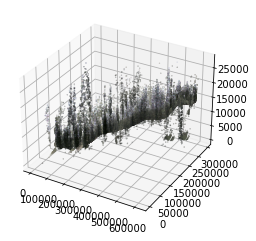

1.4591033458709717-Done.


In [4]:
from mpl_toolkits import mplot3d

dataset1 = np.vstack([las.X, las.Y, las.Z]).transpose()
print('point info:',dataset1.shape)
colors = np.vstack([las.red,las.green,las.blue]).transpose()
print('color info:',colors.shape)
classes = las.classification
print('classes of las points-{}'.format(classes))
print('size:',len(classes))
#### point cloud random subsampling #####
start = time.time()
factor = 200
decimated_points_random = dataset1[::factor]
decimated_colors = colors[::factor]
clas_decimated = classes[::factor]
print('size:',len(clas_decimated))
ax = plt.axes(projection='3d')
ax.scatter(decimated_points_random[:,0],decimated_points_random[:,1],decimated_points_random[:,2],c = decimated_colors/65535,s=0.1)
plt.show()
print('{}-Done.'.format(time.time()-start))

In [5]:
class_segmented,segmented_points,show_index = ground_segmentation(decimated_points_random,clas_decimated)


iters_inlier = 10.141749
origin data points num: 85568
segmented data points num: 83038


In [34]:
n_labels = len(set(class_segmented)) - (1 if -1 in class_segmented else 0)

In [35]:
n_labels

6

In [52]:
score

-0.2729985764811335

point numbers: 83385


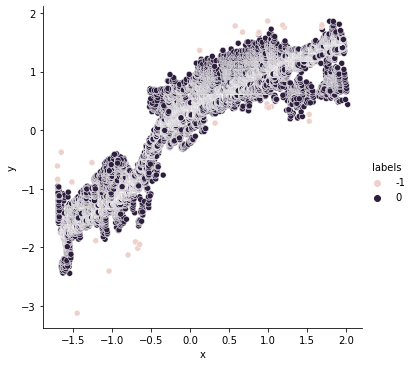

In [50]:
data = pd.DataFrame(data_new[:,:2])
data.columns=['x','y']
db = DBSCAN(eps=0.1,min_samples =6).fit(data)
data['labels'] = db.labels_
labels = db.labels_
print('point numbers:',len(data))
#sns.relplot(x="x",y="y",data=data)
#ratio
sns.relplot(x="x",y="y", hue="labels",data=data)

the execution time of dbscan 0 is:2.1121761798858643s
adjusted_rand_score: -0.2729985764811335


/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


the execution time of dbscan 1 is:3.935243844985962s
adjusted_rand_score: 0.0869346645712612


/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


the execution time of dbscan 2 is:6.222958564758301s
adjusted_rand_score: 0.12334083423568368


/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


the execution time of dbscan 3 is:7.979034900665283s
adjusted_rand_score: 0.06721391863787493


/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


the execution time of dbscan 4 is:10.402411699295044s
adjusted_rand_score: 0.15099860284699454


/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


the execution time of dbscan 5 is:11.88525915145874s
adjusted_rand_score: 0.03260064483487157


/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


the execution time of dbscan 6 is:13.815682649612427s
adjusted_rand_score: 0.10378131759789426


/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


the execution time of dbscan 7 is:15.230749368667603s
adjusted_rand_score: 0.021960992712017985


/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


the execution time of dbscan 8 is:17.104060888290405s
adjusted_rand_score: 0.03260064483487157


/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


the execution time of dbscan 9 is:19.84588074684143s
adjusted_rand_score: -0.13830004633458182


/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


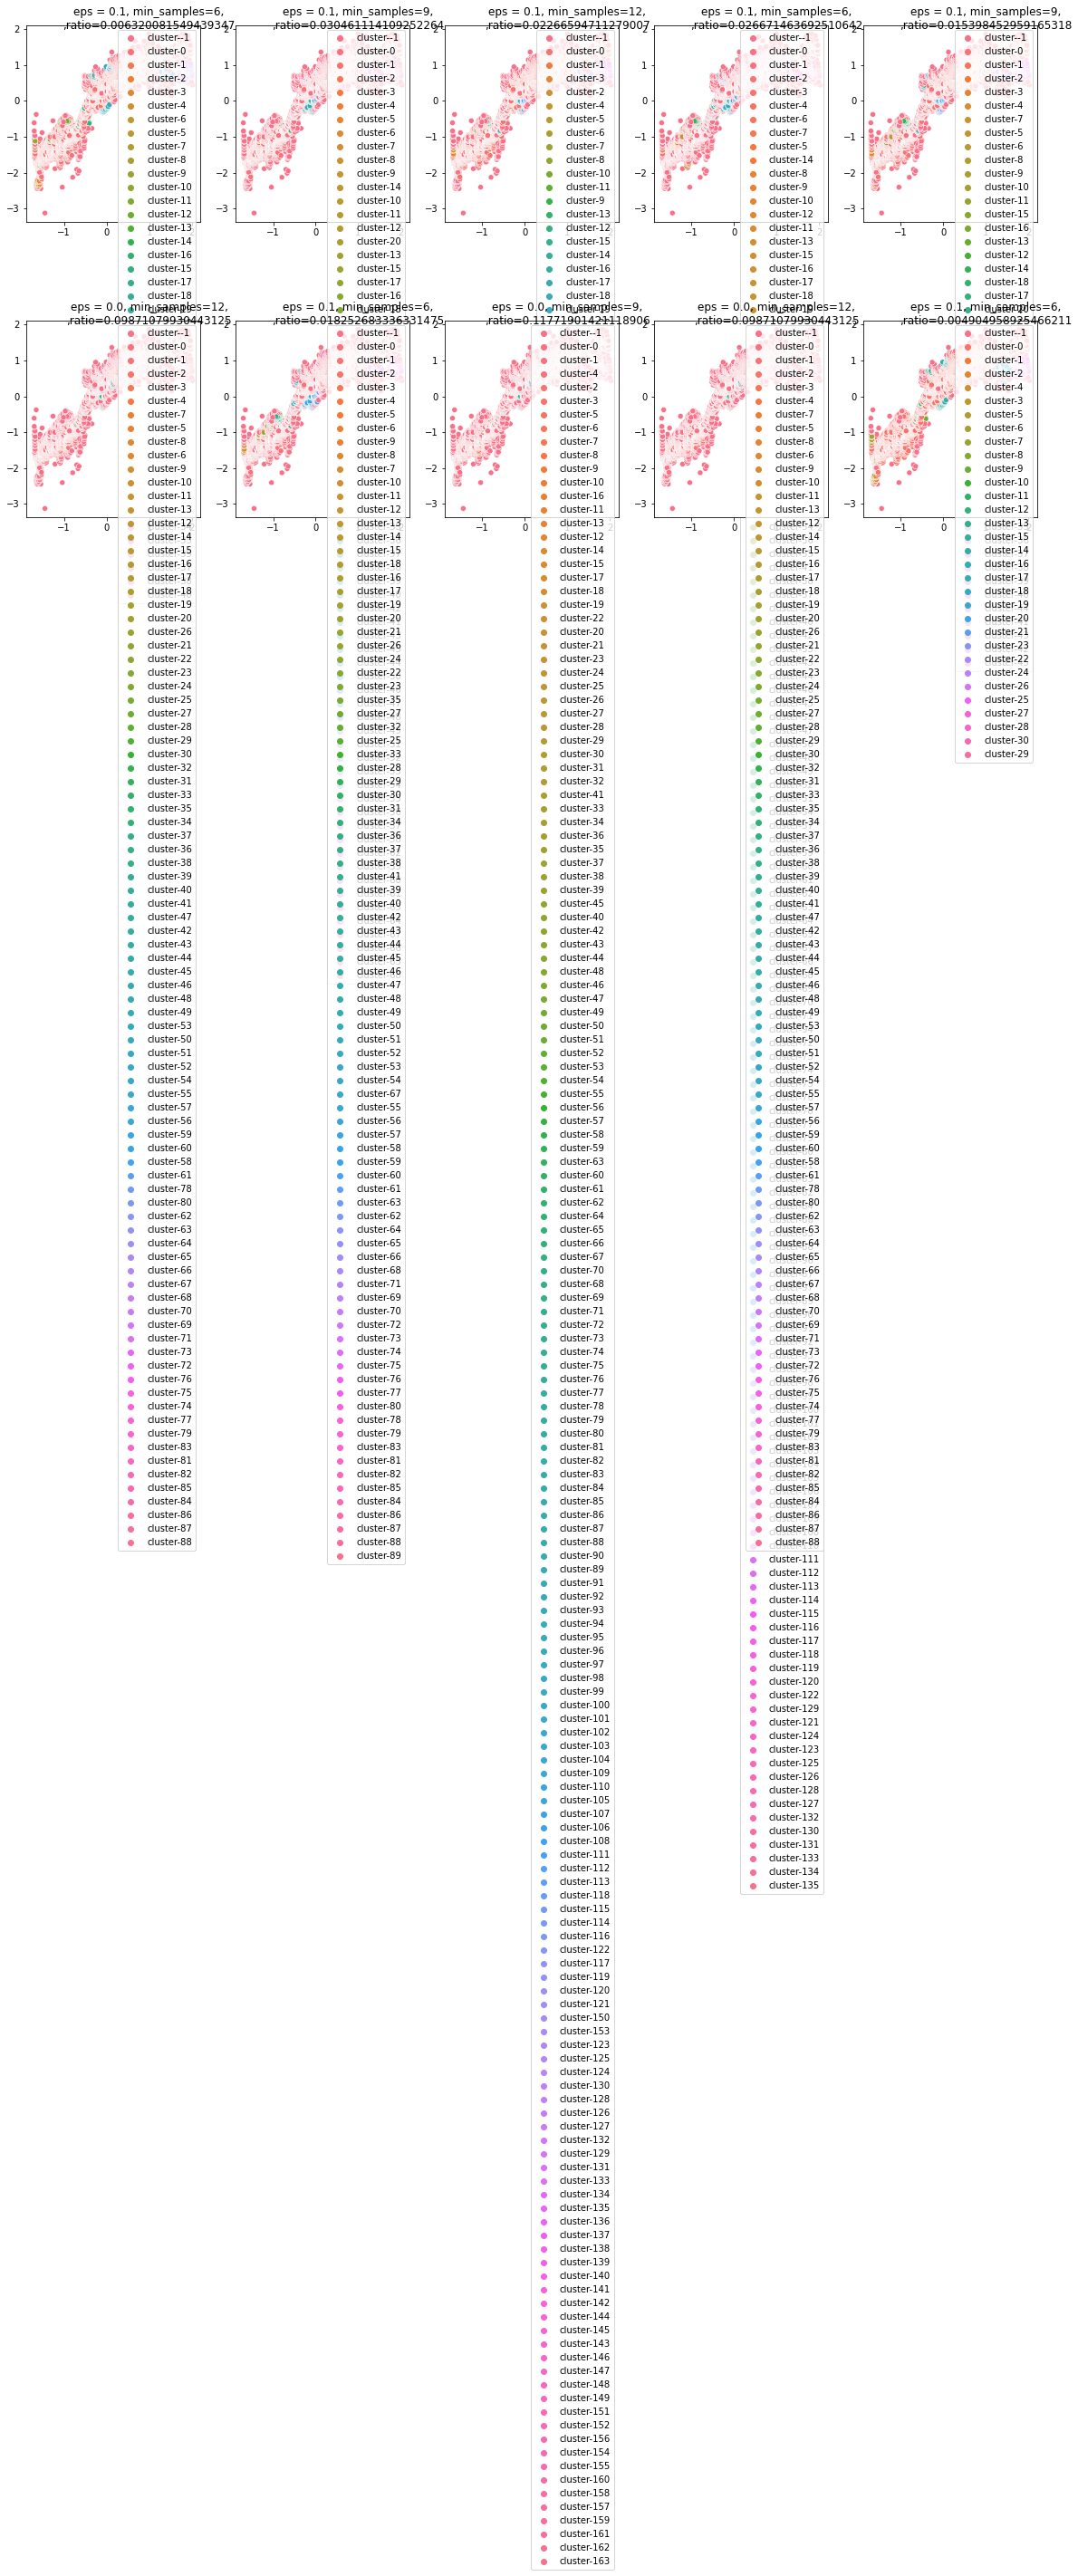

In [54]:
data1 = segmented_points[:,0:3]

#scalling
transfer = StandardScaler()
data_new = transfer.fit_transform(data1)
data = pd.DataFrame(data_new[:,:2])
data.columns=['x','y']
#plotting
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=.5,wspace=.2)

min_sams = np.arange(6,15,3)
eps_set = np.arange(0.01,0.8,0.01)
start = time.time()
max_score = 0.0003
#for x in range(5,0,-1):
for i in range(10):
    n = random.randint(1,10)
    eps = eps_set[n]
    #eps = 1/(11-x) #first-1,snd-0.6
    db = DBSCAN(eps=eps,min_samples = min_sams[i%3]).fit(data_new)
    min_samples = min_sams[i%3]
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    ax = fig.add_subplot(2, 5, i+1)
    data['labels'] = db.labels_ #

    ratio = data.loc[data['labels']==-1].x.count()/data.x.count() #the ratio of noisy points 
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) # cluster numbers

    end = time.time()
    print('the execution time of dbscan {} is:{}s'.format(i,(end-start)))
    score = metrics.adjusted_rand_score(class_segmented, labels)  
    max_score = max(score,max_score)
    print('adjusted_rand_score:',score)
    ax.text(1, 2, "eps = {}, min_samples={},\n,ratio={}".format(round(eps, 1),min_samples,ratio), fontsize=12, ha="center")
    sns.scatterplot(data_new[:,0], data_new[:,1], hue=["cluster-{}".format(x) for x in labels])

plt.savefig('visualize_comparison.png')

cluster number is: 41
the execution time of dbscan is: 2.100181818008423


/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


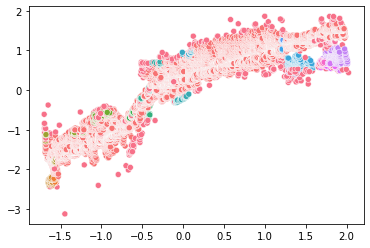

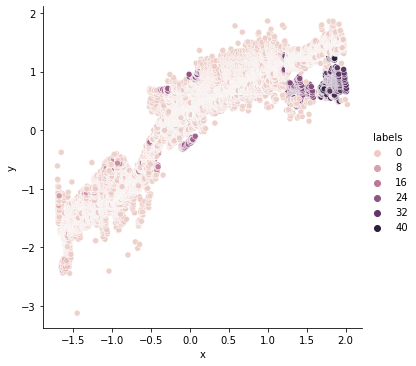

In [53]:
###test only one parameter pair####
'''
1: calculate the noisy points and get the ratio
2: cluster numbers
3: add a silhoutee score as metric 
'''
start = time.time()
db = DBSCAN(eps=0.1,min_samples =6).fit(data_new)
labels = db.labels_
data['labels'] = db.labels_ #

ratio = data.loc[data['labels']==-1].x.count()/data.x.count() #the ratio of noisy points 
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) # cluster numbers
print('cluster number is:',n_clusters_)
end = time.time()
print('the execution time of dbscan is:',(end-start))
score = metrics.adjusted_rand_score(class_segmented, labels)  
ax.text(1, 2, "eps = {}, min_samples={},\n,ratio={}".format(round(eps, 1),min_samples,ratio), fontsize=12, ha="center")
sns.scatterplot(data_new[:,0], data_new[:,1], hue=["cluster-{}".format(x) for x in labels],legend =False)
data = pd.DataFrame(data_new[:,:2])
data.columns=['x','y']
data['labels'] = db.labels_
labels = db.labels_

#ratio
sns.relplot(x="x",y="y", hue="labels",data=data)
plt.savefig('to_Show.png')

In [20]:
max_score

0.02719761383487829

/home/tsgleeds2021/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


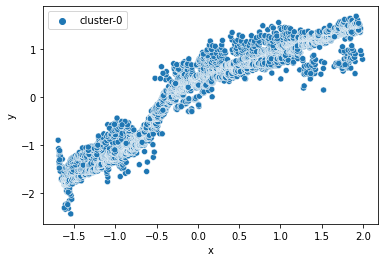

In [12]:
data_subset1 = data.loc[data['labels'] == 0]
sns.scatterplot(data_subset1.x, data_subset1.y, hue=["cluster-{}".format(x) for x in data_subset1.labels])
plt.show()

In [74]:
data_subset1

,x,y,labels
9240,1.822703,0.649987,5
9241,1.836421,0.645059,5
9248,1.831755,0.629394,5
9258,1.715546,0.712870,5
9262,1.770814,0.674097,5
9268,1.807460,0.679568,5
9292,1.791336,0.684767,5


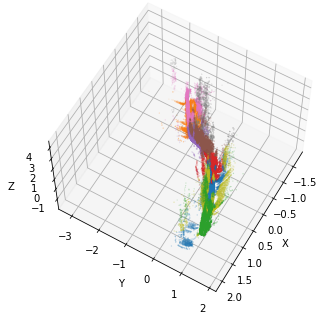

time of K-Means: 1.014209508895874


<Figure size 432x288 with 0 Axes>

In [11]:
#### KMeans clustering ####
from mpl_toolkits.mplot3d import Axes3D
data1 = segmented_points[:,0:3]
#scalling
transfer = StandardScaler()
data_new = transfer.fit_transform(data1)
start = time.time()
#pre-predict 
estimator = KMeans(n_clusters = 9)
estimator.fit(data_new)
y_pred = estimator.predict(data_new)
end = time.time()

fig = plt.figure()
ax = Axes3D(fig)
for i in range(9):
    ax.scatter3D(data_new[y_pred == i,0],data_new[y_pred == i,1],data_new[y_pred == i,2],marker = ".",s=0.1)
ax.view_init(elev = 60,azim = 30)
ax.set_zlabel('Z')
ax.set_ylabel('Y')
ax.set_xlabel('X')
plt.show() 
plt.savefig('visualize_kmeans.png')
print('time of K-Means:',end-start)